<a href="https://colab.research.google.com/github/chuan137/egohands/blob/master/grocery/grocery_categories_v05_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note

__Description__ Select three categories for training. Expect better train and validation accuracies than training all categories. Relative simple architecture. Noticable overfitting. Training accuracies > 0.95. Validation accuracies ~0.8.

* *v03-a* -- No fully connected layer, prediction layer with L2 regularizer
* *v03-b* -- FC layer, prediction layer with L2 regularizer
* *v03-c* -- FC layer w/ L2 regularizer, prediction layer w/o regularizer
* *v03-d* -- Dropout layer before FC layer


__Update__
* use orignal png images
* No augmentation
* use tf dataset to generate batch

## Training Details

**Train data**
* 3 categories: BEANS, CAKE, CANDY 
* image size 224
* \# training set 568
* \# validation set 67

**Architecture**
* **NO** fully connected layer
* prediction layer with L2 regularizer

**Hyper parameters**
* softmax layer with regularizer, weight = 0.0001
* optimizer Adam, learning rate 0.0001



## Prepare

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cp /content/drive/My\ Drive/freiburg_groceries_dataset.zip .
!unzip -q freiburg_groceries_dataset.zip

## Load Data

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


* split train and test images

In [0]:
import os
import random
import pandas as pd

def find_images(dpath, subdir=''):
    """ return [](filepath, label) """
    images = []
    if os.path.isdir(os.path.join(dpath, subdir)):
        for filename in os.listdir(os.path.join(dpath, subdir)):
            filepath = os.path.join(subdir, filename)
            images.append(filepath)
    return images


def split_images(images, splits):
    'shuffle and split images[] to train[], validation and test[]'
    if type(splits) not in (list, tuple):
        raise TypeError("splits must be list or tuple")
    elif abs(sum(splits) - 1.0) > 0.000001:
        raise ValueError("sum of splits should be 1.0")
    elif len(splits) not in (2, 3):
        raise ValueError("splits should have 2 or 3 elements") 
    random.shuffle(images)
    n = len(images)
    if len(splits) == 2:
        n1, _ = [round(x*n) for x in splits]
        print(n1)
        return images[:n1], images[n1:]
    else:
        n1, n2, _ = [round(x*n) for x in splits]
        return images[:n1], images[n1:n1+n2], images[n1+n2:]

all_classes = next(os.walk('images'))[1]

train = []
val = []
test = []
splits = (0.8, 0.1, 0.1)
for cl in all_classes:
    images = find_images('images', cl)
    tr, v, te = split_images(images, splits)
    train += zip(tr, [cl] * len(tr))
    val += zip(v, [cl] * len(v))
    test += zip(te, [cl] * len(te))

train_df = pd.DataFrame(train, columns=['filename', 'class'])
val_df = pd.DataFrame(val, columns=['filename', 'class'])
test_df = pd.DataFrame(test, columns=['filename', 'class'])


* create data generator for training

In [0]:
IMAGE_SIZE = 96
BATCH_SIZE = 32
seed = 76

classes = ['BEANS', 'CAKE', 'CANDY']
n_classes = len(classes)
classmap = {c: i for i, c in enumerate(classes)}
img_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [0]:
import os
labels_count = dict()
for img_class in classes:
    labels_count[img_class] = len(os.listdir('images/' + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in 
                 enumerate(labels_count.values())}
class_weights

{0: 4.919117647058823, 1: 4.15527950310559, 2: 1.7983870967741935}

In [0]:
train_dataset = train_df[train_df['class'].isin(classes)]
train_filenames = train_dataset['filename'].tolist()
train_labels = train_dataset['class'].tolist()
train_labels = [classmap[l] for l in train_labels]
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=n_classes)

val_dataset = val_df[val_df['class'].isin(classes)]
val_filenames = val_dataset['filename'].tolist()
val_labels = val_dataset['class'].tolist()
val_labels = [classmap[l] for l in val_labels]
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=n_classes)

test_dataset = test_df[test_df['class'].isin(classes)]
test_filenames = test_dataset['filename'].tolist()
test_labels = test_dataset['class'].tolist()
test_labels = [classmap[l] for l in test_labels]
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=n_classes)

len(train_filenames), len(val_filenames), len(test_filenames)

(536, 67, 66)

In [0]:
# Function to load and preprocess each image
def _parse_fn(filename, label):
    filename = 'images/' + filename
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img)
    img = (tf.cast(img, tf.float32)/127.5) - 1
    # img = tf.cast(img, tf.float32)/255.0
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img, label

train_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(train_filenames), tf.constant(train_labels))
)

val_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(val_filenames), tf.constant(val_labels))
)

test_data = tf.data.Dataset.from_tensor_slices(
    (tf.constant(test_filenames), tf.constant(test_labels))
)

train_data = (train_data.shuffle(buffer_size=len(train_filenames))
             .map(_parse_fn)
             .batch(BATCH_SIZE)
)

val_data = (val_data.shuffle(buffer_size=len(val_filenames))
            .map(_parse_fn)
            .batch(BATCH_SIZE)
)

test_data = (test_data.map(_parse_fn))

n_train = len(train_filenames)
n_val = len(val_filenames)
n_train, n_val

(536, 67)

 * build train model

In [0]:
import tensorflow as tf
from tensorflow.keras import regularizers

w_l2 = 0.0001

# Pre-trained model with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained model weights
base_model.trainable = False

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
# fc_layer_1 = tf.keras.layers.Dense(1280, activation='relu')

# Prediction with L2 regularizer
prediction_layer = tf.keras.layers.Dense(
    n_classes, 
    kernel_regularizer=regularizers.l2(w_l2), 
    activation='softmax')

# Layer classification head with feature detector
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    # fc_layer_1,
    prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
epochs = 50
learning_rate = 0.0001

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

steps_per_epoch = round(n_train/BATCH_SIZE)
validation_steps = round(n_val/BATCH_SIZE)

hist = model.fit(train_data.repeat(), 
                 epochs=epochs,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=val_data.repeat(),
                 validation_steps=validation_steps,
                 class_weight=class_weights)


Train for 17 steps, validate for 2 steps
Epoch 1/50
17/17 [==============================] - 7s 411ms/step - loss: 1.9401 - accuracy: 0.4795 - val_loss: 2.2631 - val_accuracy: 0.3594
Epoch 2/50
17/17 [==============================] - 3s 173ms/step - loss: 1.7614 - accuracy: 0.4944 - val_loss: 2.1682 - val_accuracy: 0.3438
Epoch 3/50
17/17 [==============================] - 3s 174ms/step - loss: 1.6020 - accuracy: 0.5336 - val_loss: 2.0810 - val_accuracy: 0.3438
Epoch 4/50
17/17 [==============================] - 3s 176ms/step - loss: 1.4505 - accuracy: 0.5597 - val_loss: 1.7569 - val_accuracy: 0.3906
Epoch 5/50
17/17 [==============================] - 3s 174ms/step - loss: 1.2786 - accuracy: 0.6045 - val_loss: 1.7459 - val_accuracy: 0.4219
Epoch 6/50
17/17 [==============================] - 3s 176ms/step - loss: 1.2756 - accuracy: 0.5877 - val_loss: 1.5109 - val_accuracy: 0.4688
Epoch 7/50
17/17 [==============================] - 3s 176ms/step - loss: 1.1975 - accuracy: 0.6138 - val_l

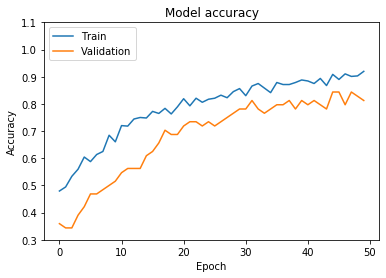

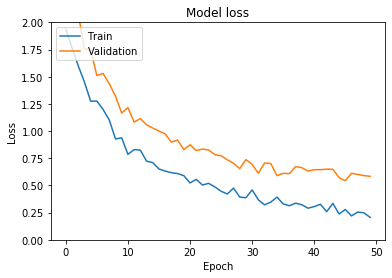

In [0]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.3, 1.1)
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,2)
plt.show()

In [0]:
epochs = 100
learning_rate = 0.0001

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

steps_per_epoch = round(n_train/BATCH_SIZE)
validation_steps = round(n_val/BATCH_SIZE)

hist = model.fit(train_data.repeat(), 
                 epochs=epochs,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=val_data.repeat(),
                 validation_steps=validation_steps,
                 class_weight=class_weights)


Train for 17 steps, validate for 2 steps
Epoch 1/100
17/17 [==============================] - 7s 423ms/step - loss: 0.2595 - accuracy: 0.8993 - val_loss: 0.5657 - val_accuracy: 0.8281
Epoch 2/100
17/17 [==============================] - 3s 174ms/step - loss: 0.2814 - accuracy: 0.9104 - val_loss: 0.6006 - val_accuracy: 0.8281
Epoch 3/100
17/17 [==============================] - 3s 174ms/step - loss: 0.2100 - accuracy: 0.9104 - val_loss: 0.5864 - val_accuracy: 0.8281
Epoch 4/100
17/17 [==============================] - 3s 175ms/step - loss: 0.2118 - accuracy: 0.9086 - val_loss: 0.5316 - val_accuracy: 0.8281
Epoch 5/100
17/17 [==============================] - 3s 173ms/step - loss: 0.2119 - accuracy: 0.9142 - val_loss: 0.5536 - val_accuracy: 0.8281
Epoch 6/100
17/17 [==============================] - 3s 176ms/step - loss: 0.1994 - accuracy: 0.9067 - val_loss: 0.5692 - val_accuracy: 0.8125
Epoch 7/100
17/17 [==============================] - 3s 176ms/step - loss: 0.2008 - accuracy: 0.9160 

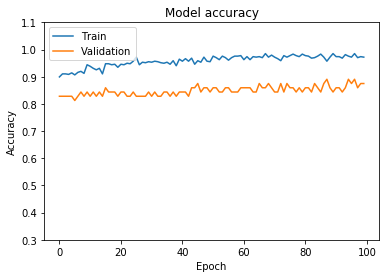

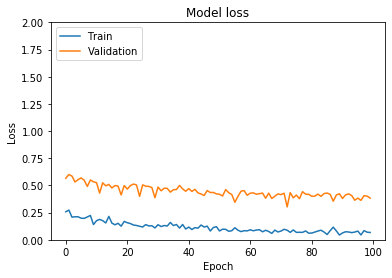

In [0]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.3, 1.1)
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,2)
plt.show()

In [0]:
import numpy as np

x_data = []
y_data = []
for x, y in test_data.repeat(1):
    x_data.append(x)
    y_data.append(y)

x_data = np.vstack(x_data).reshape(-1,96,96,3)
predictions = model.predict_classes(x_data)

for i in range(len(y_data)):
    print(y_data[i], predictions[i])


tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 0
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 1
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32) 2
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32) 0
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32) 0
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32) 0
tf.Tensor([1. 0. 0.], shape=(3,

In [0]:
model.save('drive/My Drive/Colab Notebooks/grocery-categories-v05-a.h5')
model.save_weights('drive/My Drive/Colab Notebooks/grocery-categories-v05-a.weights.h5')